In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Пути к данным
train_dir = 'cat-breed/TRAIN'
test_dir = 'cat-breed/TEST'

# Проверка существования папок
if not os.path.exists(train_dir):
    print(f"Ошибка: Папка {train_dir} не существует!")
    raise FileNotFoundError(f"Папка {train_dir} не найдена!")
if not os.path.exists(test_dir):
    print(f"Ошибка: Папка {test_dir} не существует!")
    raise FileNotFoundError(f"Папка {test_dir} не найдена!")

# Получение списка пород
breeds = sorted(os.listdir(train_dir))
print(f"Найдено {len(breeds)} пород: {breeds}")

Используется устройство: cuda
Найдено 6 пород: ['americanshorthair', 'bengal', 'mainecoon', 'ragdoll', 'scottishfold', 'sphinx']


In [3]:
# Определение аугментаций и трансформаций
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Трансформация для единичного изображения
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Создание датасета
class CatBreedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.breed_to_idx = {breed: i for i, breed in enumerate(breeds)}
        
        for breed in breeds:
            breed_dir = os.path.join(root_dir, breed)
            if os.path.exists(breed_dir):
                for img_name in os.listdir(breed_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(breed_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.breed_to_idx[breed])
        
        print(f"Загружено {len(self.images)} изображений из {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Создание модели
class CatBreedClassifier(nn.Module):
    def __init__(self, num_breeds=6):
        super(CatBreedClassifier, self).__init__()
        # Используем предобученную ResNet
        self.model = models.resnet50(pretrained=True)
        
        # Замораживаем начальные слои
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Заменяем последний слой
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_breeds)
        )
    
    def forward(self, x):
        return self.model(x)

In [7]:
# Создание датасетов и DataLoader
print("Создание датасетов...")
train_dataset = CatBreedDataset(train_dir, transform=train_transform)
test_dataset = CatBreedDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

Создание датасетов...
Загружено 1200 изображений из cat-breed/TRAIN
Загружено 299 изображений из cat-breed/TEST


In [8]:
# Инициализация модели
model = CatBreedClassifier(num_breeds=len(breeds)).to(device)
print("Модель инициализирована!")

Модель инициализирована!


In [9]:
# Функции для обучения
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Обучение")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'Loss': running_loss/total, 'Acc': 100*correct/total})
    
    return running_loss/len(loader), 100*correct/total

In [10]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Валидация")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'Loss': running_loss/total, 'Acc': 100*correct/total})
    
    return running_loss/len(loader), 100*correct/total

In [11]:
def train_model(model, train_loader, test_loader, num_epochs=10, model_path='cat_breed_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Валидация
        val_loss, val_acc = validate(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc,
                'breeds': breeds
            }, model_path)
            print(f"Модель сохранена в {model_path} с точностью {val_acc:.2f}%")
        
        print(f"Итоги эпохи {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Визуализация результатов
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Эпохи')
    ax1.set_ylabel('Потери')
    ax1.set_title('Потери при обучении')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(val_accs, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Эпохи')
    ax2.set_ylabel('Точность (%)')
    ax2.set_title('Точность при обучении')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, train_accs, val_losses, val_accs


НАЧАЛО ОБУЧЕНИЯ

Эпоха 1/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.71it/s, Loss=0.0454, Acc=76.6]


Модель сохранена в cat_breed_model.pth с точностью 76.59%
Итоги эпохи 1:
Train Loss: 1.6488, Train Acc: 38.75%
Val Loss: 1.3572, Val Acc: 76.59%

Эпоха 2/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.31it/s, Loss=0.0327, Acc=70.9]


Итоги эпохи 2:
Train Loss: 1.3068, Train Acc: 61.33%
Val Loss: 0.9783, Val Acc: 70.90%

Эпоха 3/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.0241, Acc=82.6]


Модель сохранена в cat_breed_model.pth с точностью 82.61%
Итоги эпохи 3:
Train Loss: 1.0168, Train Acc: 71.25%
Val Loss: 0.7219, Val Acc: 82.61%

Эпоха 4/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.05it/s, Loss=0.0198, Acc=85.3]


Модель сохранена в cat_breed_model.pth с точностью 85.28%
Итоги эпохи 4:
Train Loss: 0.8880, Train Acc: 73.83%
Val Loss: 0.5932, Val Acc: 85.28%

Эпоха 5/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.22it/s, Loss=0.0169, Acc=86.6]


Модель сохранена в cat_breed_model.pth с точностью 86.62%
Итоги эпохи 5:
Train Loss: 0.7683, Train Acc: 75.92%
Val Loss: 0.5040, Val Acc: 86.62%

Эпоха 6/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s, Loss=0.0164, Acc=87.6]


Модель сохранена в cat_breed_model.pth с точностью 87.63%
Итоги эпохи 6:
Train Loss: 0.7339, Train Acc: 76.58%
Val Loss: 0.4899, Val Acc: 87.63%

Эпоха 7/10
--------------------------------------------------


Валидация: 100%|███████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s, Loss=0.016, Acc=87]


Итоги эпохи 7:
Train Loss: 0.7328, Train Acc: 76.50%
Val Loss: 0.4778, Val Acc: 86.96%

Эпоха 8/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.10it/s, Loss=0.0157, Acc=86.6]


Итоги эпохи 8:
Train Loss: 0.7040, Train Acc: 78.92%
Val Loss: 0.4709, Val Acc: 86.62%

Эпоха 9/10
--------------------------------------------------


Валидация: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.09it/s, Loss=0.0162, Acc=85.6]


Итоги эпохи 9:
Train Loss: 0.7386, Train Acc: 76.00%
Val Loss: 0.4830, Val Acc: 85.62%

Эпоха 10/10
--------------------------------------------------


Валидация: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s, Loss=0.0157, Acc=87]


Итоги эпохи 10:
Train Loss: 0.7110, Train Acc: 76.58%
Val Loss: 0.4695, Val Acc: 86.96%


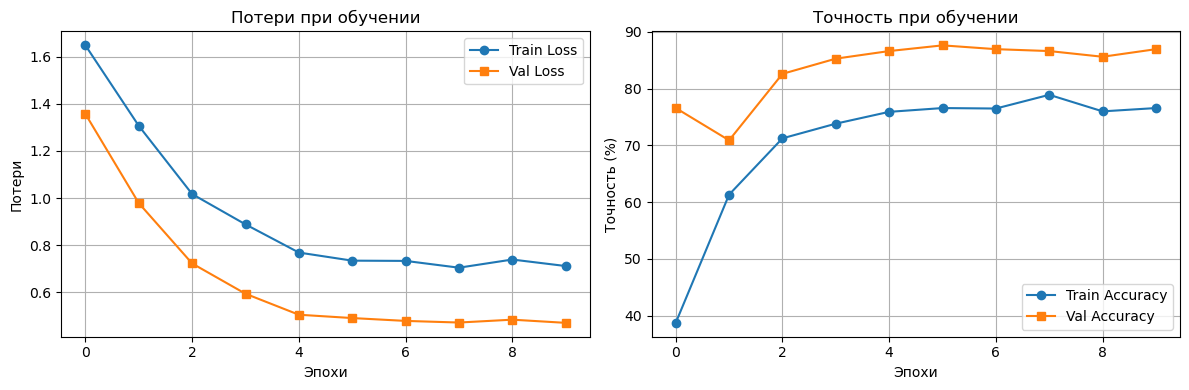


Обучение завершено! Лучшая точность: 87.63%


In [19]:
# Обучаем модель
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ")
print("="*50)

train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, num_epochs=10, model_path='cat_breed_model.pth'
)

print(f"\nОбучение завершено! Лучшая точность: {max(val_accs):.2f}%")

In [20]:
# Функция для предсказания породы по изображению
def predict_breed(image_path, model, device, show_image=True):
    """
    Предсказывает породу кошки по изображению
    
    Args:
        image_path (str): Путь к изображению
        model: Обученная модель
        device: Устройство (cuda/cpu)
        show_image (bool): Показывать ли изображение
    
    Returns:
        dict: Результаты предсказания
    """
    model.eval()
    
    # Проверка существования файла
    if not os.path.exists(image_path):
        print(f"Ошибка: Файл '{image_path}' не найден!")
        return None
    
    try:
        # Загрузка изображения
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        
        # Применение трансформаций
        image_tensor = predict_transform(image).unsqueeze(0).to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            probs, indices = torch.topk(probabilities, k=3)  # Топ-3 предсказания
        
        # Преобразование результатов
        top_probs = probs[0].cpu().numpy()
        top_indices = indices[0].cpu().numpy()
        
        results = {
            'image_path': image_path,
            'filename': os.path.basename(image_path),
            'predictions': []
        }
        
        for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
            breed = breeds[idx]
            results['predictions'].append({
                'rank': i + 1,
                'breed': breed,
                'probability': float(prob),
                'percentage': float(prob) * 100
            })
        
        # Визуализация
        if show_image:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Оригинальное изображение
            axes[0].imshow(original_image)
            axes[0].set_title(f"Исходное изображение\n{results['filename']}", fontsize=14, pad=15)
            axes[0].axis('off')
            
            # График вероятностей
            breeds_list = [f"{p['breed']}" for p in results['predictions']]
            probs_list = [p['percentage'] for p in results['predictions']]
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
            
            bars = axes[1].barh(range(len(probs_list)), probs_list, color=colors, height=0.6)
            axes[1].set_yticks(range(len(probs_list)))
            axes[1].set_yticklabels(breeds_list, fontsize=12)
            axes[1].set_xlabel('Вероятность (%)', fontsize=12)
            axes[1].set_title('Топ-3 предсказанные породы', fontsize=14, pad=15)
            axes[1].set_xlim([0, 100])
            axes[1].grid(axis='x', alpha=0.3)
            
            # Добавление значений на график
            for i, (bar, prob) in enumerate(zip(bars, probs_list)):
                width = bar.get_width()
                axes[1].text(width + 1, bar.get_y() + bar.get_height()/2,
                           f'{prob:.1f}%', va='center', fontsize=12, fontweight='bold')
                
                # Добавляем номер места
                axes[1].text(3, bar.get_y() + bar.get_height()/2,
                           f'{i+1}.', ha='right', va='center', 
                           fontsize=14, color='white', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        
        # Вывод результатов в консоль
        print("\n" + "="*60)
        print("РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ")
        print("="*60)
        print(f"Изображение: {results['filename']}")
        print(f"Путь: {image_path}")
        print("\nТоп-3 предсказанные породы:")
        print("-" * 60)
        print(f"{'№':<3} {'Порода':<20} {'Вероятность':<15} {'%':<10}")
        print("-" * 60)
        
        for pred in results['predictions']:
            stars = "★" * pred['rank'] + "☆" * (3 - pred['rank'])
            print(f"{pred['rank']:<3} {pred['breed']:<20} {pred['probability']:<15.4f} {pred['percentage']:<10.2f}% {stars}")
        
        print("="*60)
        
        return results
        
    except Exception as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None

In [21]:
# Функция для загрузки модели (если нужно перезагрузить)
def load_model(model_path='cat_breed_model.pth'):
    checkpoint = torch.load(model_path, map_location=device)
    model = CatBreedClassifier(num_breeds=len(breeds)).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Модель загружена из {model_path}")
    print(f"Точность модели при обучении: {checkpoint['val_acc']:.2f}%")
    return model

In [22]:
# Интерактивное тестирование
def test_random_images(num_images=5):
    """Тестирует модель на случайных изображениях из тестового набора"""
    # Получаем список всех тестовых изображений
    all_test_images = []
    for breed in breeds:
        breed_dir = os.path.join(test_dir, breed)
        if os.path.exists(breed_dir):
            images = [os.path.join(breed_dir, img) for img in os.listdir(breed_dir) 
                     if img.endswith(('.jpg', '.jpeg', '.png'))]
            all_test_images.extend(images[:5])  # Берем по 5 от каждой породы
    
    random.shuffle(all_test_images)
    test_samples = all_test_images[:num_images]
    
    print(f"\n{'='*60}")
    print(f"ТЕСТИРОВАНИЕ НА {num_images} СЛУЧАЙНЫХ ИЗОБРАЖЕНИЯХ")
    print('='*60)
    
    for img_path in test_samples:
        true_breed = os.path.basename(os.path.dirname(img_path))
        result = predict_breed(img_path, model, device, show_image=False)
        
        if result:
            predicted_breed = result['predictions'][0]['breed']
            confidence = result['predictions'][0]['percentage']
            correct = "✓" if predicted_breed == true_breed else "✗"
            
            print(f"\n{correct} {os.path.basename(img_path)}")
            print(f"  Истинная порода: {true_breed}")
            print(f"  Предсказанная порода: {predicted_breed}")
            print(f"  Уверенность: {confidence:.1f}%")
            print(f"  Совпадение: {'Да' if predicted_breed == true_breed else 'Нет'}")

# Запустите тестирование
test_random_images(3)


ТЕСТИРОВАНИЕ НА 3 СЛУЧАЙНЫХ ИЗОБРАЖЕНИЯХ

РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ
Изображение: cute-ragdoll-kitten-blue-eyes-260nw-1867479868.jpg
Путь: cat-breed/TEST\ragdoll\cute-ragdoll-kitten-blue-eyes-260nw-1867479868.jpg

Топ-3 предсказанные породы:
------------------------------------------------------------
№   Порода               Вероятность     %         
------------------------------------------------------------
1   ragdoll              0.7631          76.31     % ★☆☆
2   mainecoon            0.1348          13.48     % ★★☆
3   scottishfold         0.0694          6.94      % ★★★

✓ cute-ragdoll-kitten-blue-eyes-260nw-1867479868.jpg
  Истинная порода: ragdoll
  Предсказанная порода: ragdoll
  Уверенность: 76.3%
  Совпадение: Да

РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ
Изображение: depositphotos_120938442-stock-photo-cute-cat-sphinx.jpg
Путь: cat-breed/TEST\sphinx\depositphotos_120938442-stock-photo-cute-cat-sphinx.jpg

Топ-3 предсказанные породы:
---------------------------------------------------------

In [23]:
# Функция для распознавания указанного изображения
def recognize_specific_image(image_path):
    """
    Распознает породу кошки на указанном изображении
    
    Args:
        image_path (str): Полный путь к изображению
    """
    print(f"\n{'='*60}")
    print(f"РАСПОЗНАВАНИЕ УКАЗАННОГО ИЗОБРАЖЕНИЯ")
    print('='*60)
    
    # Проверяем существование файла
    if not os.path.exists(image_path):
        print(f"ОШИБКА: Файл '{image_path}' не найден!")
        
        # Предлагаем альтернативы
        print("\nДоступные изображения в тестовой выборке:")
        for breed in breeds[:3]:  # Показываем только первые 3 породы
            breed_dir = os.path.join(test_dir, breed)
            if os.path.exists(breed_dir):
                images = os.listdir(breed_dir)[:2]  # Первые 2 изображения
                for img in images:
                    print(f"  cat-breed/TEST/{breed}/{img}")
        return
    
    # Распознаем изображение
    result = predict_breed(image_path, model, device, show_image=True)
    
    if result:
        print(f"\nРаспознавание завершено успешно!")
        return result
    else:
        print(f"\nНе удалось распознать изображение.")
        return None


РАСПОЗНАВАНИЕ УКАЗАННОГО ИЗОБРАЖЕНИЯ


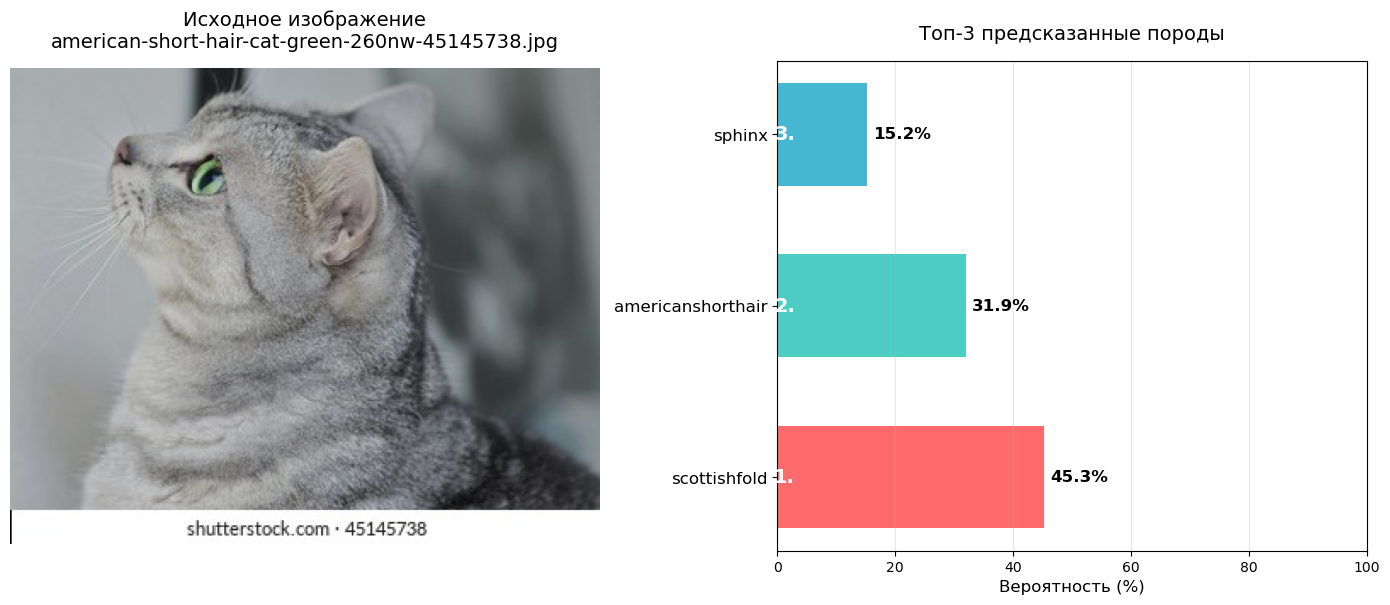


РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ
Изображение: american-short-hair-cat-green-260nw-45145738.jpg
Путь: cat-breed/TEST/americanshorthair/american-short-hair-cat-green-260nw-45145738.jpg

Топ-3 предсказанные породы:
------------------------------------------------------------
№   Порода               Вероятность     %         
------------------------------------------------------------
1   scottishfold         0.4529          45.29     % ★☆☆
2   americanshorthair    0.3192          31.92     % ★★☆
3   sphinx               0.1515          15.15     % ★★★

Распознавание завершено успешно!


{'image_path': 'cat-breed/TEST/americanshorthair/american-short-hair-cat-green-260nw-45145738.jpg',
 'filename': 'american-short-hair-cat-green-260nw-45145738.jpg',
 'predictions': [{'rank': 1,
   'breed': 'scottishfold',
   'probability': 0.4528826177120209,
   'percentage': 45.28826177120209},
  {'rank': 2,
   'breed': 'americanshorthair',
   'probability': 0.31916818022727966,
   'percentage': 31.916818022727966},
  {'rank': 3,
   'breed': 'sphinx',
   'probability': 0.15151816606521606,
   'percentage': 15.151816606521606}]}

In [24]:
image_to_recognize = "cat-breed/TEST/americanshorthair/american-short-hair-cat-green-260nw-45145738.jpg"
recognize_specific_image(image_to_recognize)

In [25]:
# Интерактивный ввод пути к изображению
def recognize_from_input():
    """Запрашивает путь к изображению у пользователя"""
    print("\n" + "="*60)
    print("РАСПОЗНАВАНИЕ ПОРОДЫ КОШКИ ПО ИЗОБРАЖЕНИЮ")
    print("="*60)
    
    while True:
        print("\nВыберите действие:")
        print("1. Указать полный путь к изображению")
        print("2. Использовать тестовое изображение")
        print("3. Выйти")
        
        try:
            choice = input("\nВаш выбор (1-3): ").strip()
            
            if choice == '1':
                # Ручной ввод пути
                img_path = input("Введите полный путь к изображению: ").strip()
                
                # Убираем кавычки если они есть
                img_path = img_path.strip('"').strip("'")
                
                # Проверка расширения файла
                if not img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    print("Предупреждение: файл должен быть изображением (jpg, jpeg, png, bmp)")
                    continue
                
                recognize_specific_image(img_path)
                
            elif choice == '2':
                # Выбор из тестовых изображений
                print("\nДоступные тестовые изображения:")
                test_images = []
                
                for i, breed in enumerate(breeds, 1):
                    breed_dir = os.path.join(test_dir, breed)
                    if os.path.exists(breed_dir):
                        images = [f for f in os.listdir(breed_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))]
                        if images:
                            # Показываем несколько изображений для каждой породы
                            for j, img_name in enumerate(images[:2], 1):  # Первые 2 изображения
                                full_path = f"cat-breed/TEST/{breed}/{img_name}"
                                test_images.append(full_path)
                                print(f"{len(test_images)}. {breed}/{img_name}")
                
                if test_images:
                    try:
                        img_choice = int(input(f"\nВыберите изображение (1-{len(test_images)}): "))
                        if 1 <= img_choice <= len(test_images):
                            recognize_specific_image(test_images[img_choice-1])
                        else:
                            print("Неверный выбор!")
                    except ValueError:
                        print("Пожалуйста, введите число!")
                else:
                    print("Тестовые изображения не найдены!")
                    
            elif choice == '3':
                print("Выход...")
                break
                
            else:
                print("Неверный выбор. Попробуйте снова.")
                
        except KeyboardInterrupt:
            print("\n\nПрограмма прервана пользователем.")
            break
        except Exception as e:
            print(f"Произошла ошибка: {e}")


РАСПОЗНАВАНИЕ ПОРОДЫ КОШКИ ПО ИЗОБРАЖЕНИЮ

Выберите действие:
1. Указать полный путь к изображению
2. Использовать тестовое изображение
3. Выйти



Ваш выбор (1-3):  2



Доступные тестовые изображения:
1. americanshorthair/american-short-hair-cat-green-260nw-45145738.jpg
2. americanshorthair/american-short-hair-cat-looking-260nw-1791927380.jpg
3. bengal/beautiful-cat-bengali-breed-young-260nw-1067883026.jpg
4. bengal/beautiful-goldencolored-bengal-cat-on-260nw-1727556838.jpg
5. mainecoon/C-yt0fzU0AAa6Nc.jpg
6. mainecoon/close-portrait-black-tabby-maine-260nw-649354312.jpg
7. ragdoll/cut-rag-doll-cat-inside-260nw-1578170593.jpg
8. ragdoll/cute-ragdoll-cat-outdoors-nature-260nw-1858240072.jpg
9. scottishfold/fluffy-gray-beautiful-adult-cat-260nw-104392901.jpg
10. scottishfold/fluffy-gray-beautiful-adult-cat-260nw-117976468.jpg
11. sphinx/depositphotos_107882650-stock-photo-sphynx-cats-inside-a-woo.jpg
12. sphinx/depositphotos_120938442-stock-photo-cute-cat-sphinx.jpg



Выберите изображение (1-12):  3



РАСПОЗНАВАНИЕ УКАЗАННОГО ИЗОБРАЖЕНИЯ


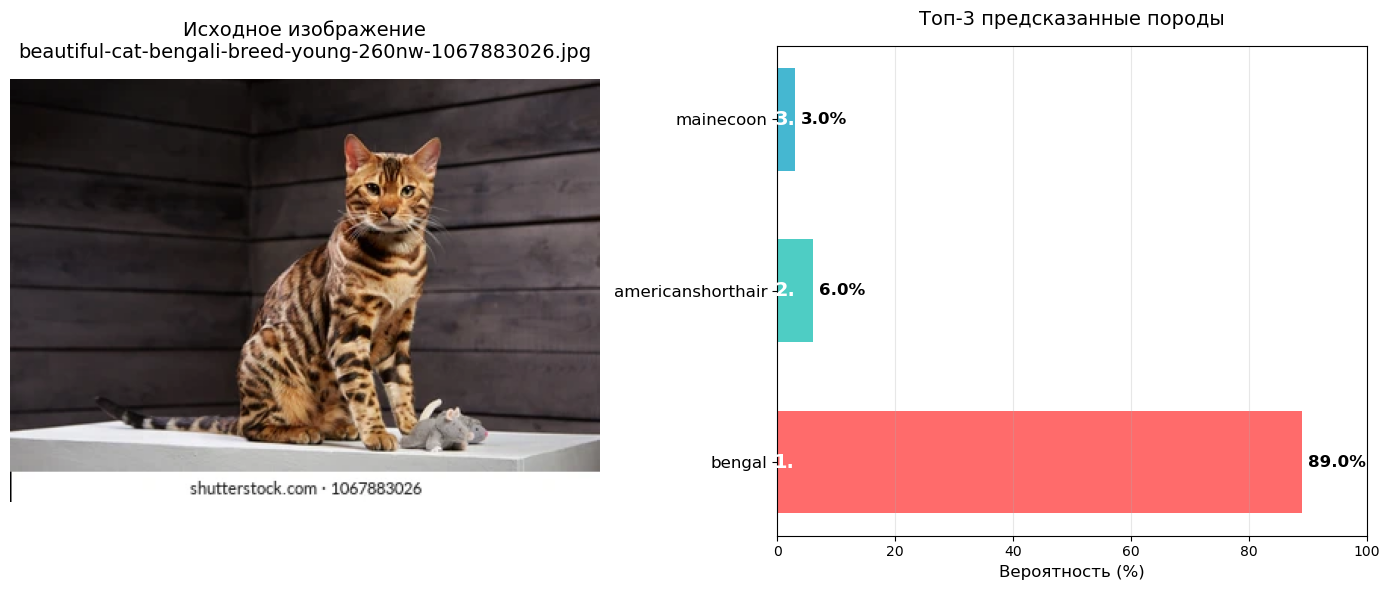


РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ
Изображение: beautiful-cat-bengali-breed-young-260nw-1067883026.jpg
Путь: cat-breed/TEST/bengal/beautiful-cat-bengali-breed-young-260nw-1067883026.jpg

Топ-3 предсказанные породы:
------------------------------------------------------------
№   Порода               Вероятность     %         
------------------------------------------------------------
1   bengal               0.8902          89.02     % ★☆☆
2   americanshorthair    0.0597          5.97      % ★★☆
3   mainecoon            0.0301          3.01      % ★★★

Распознавание завершено успешно!

Выберите действие:
1. Указать полный путь к изображению
2. Использовать тестовое изображение
3. Выйти



Ваш выбор (1-3):  3


Выход...


In [26]:
recognize_from_input()